# Usage: scenario analysis
This is a quick tour of CovsirPhy. Details scenario analysis will be explained.
"Scenario analysis" means that we calculate the number of cases in the future phases with some sets of ODE parameter values. With this analysis, we can estimate the impact of our activities against the outbreak on the number of cases.

### Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.13.3-kappa.new.56.280.420.422.429.449.475.fix.438.441.450'

### Dataset preparation
Download the datasets to "input" direcotry and load them.  
Please refer to [Usage: datasets](https://lisphilar.github.io/covid19-sir/usage_dataset.html) for the details.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt()

### Start scenario analysis
As an example, we will analysis the number of cases in Japan.

In [5]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot. Some kind of complement will be done for analysis, if necessary.

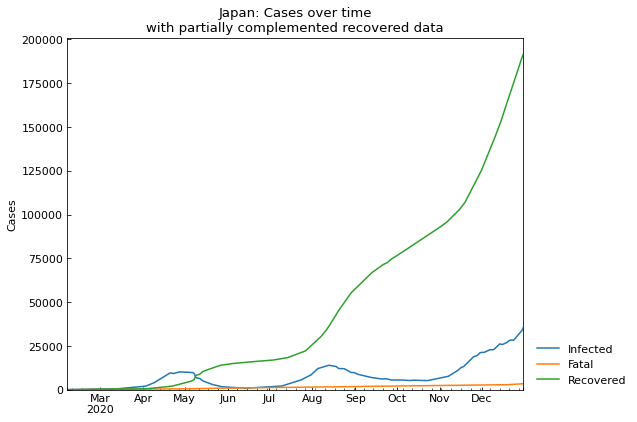

,Date,Infected,Fatal,Recovered
325,2020-12-27,31503,3213,182596
326,2020-12-28,32322,3252,184662
327,2020-12-29,32868,3306,186946
328,2020-12-30,33781,3349,189466
329,2020-12-31,35439,3414,191451


In [6]:
record_df = snl.records()
record_df.tail()

We can calculate the number of daily new cases with `Scenario.record_diff()` method.

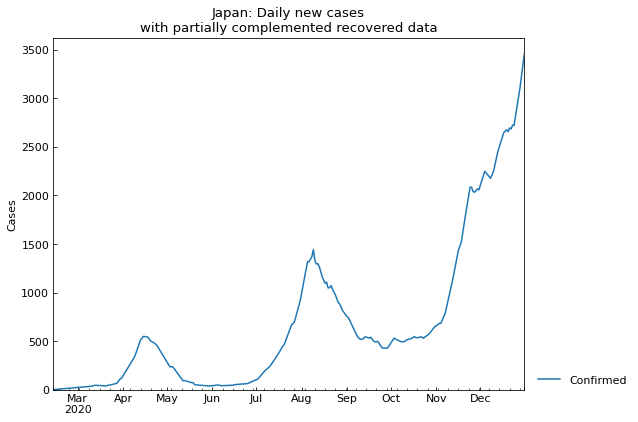

In [7]:
_ = snl.records_diff(variables=["Confirmed"], window=7)

### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

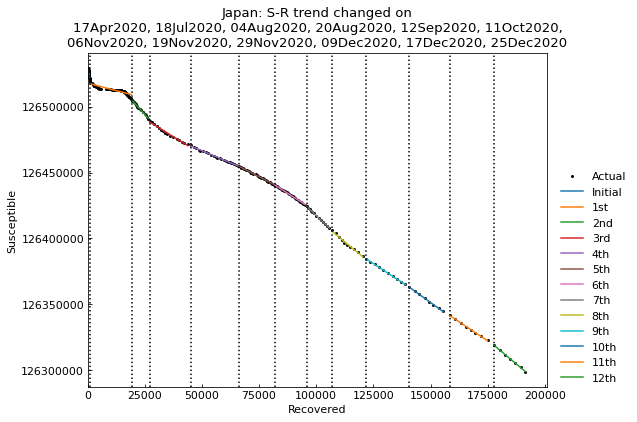

,Type,Start,End,Population
0th,Past,06Feb2020,16Apr2020,126529100
1st,Past,17Apr2020,17Jul2020,126529100
2nd,Past,18Jul2020,03Aug2020,126529100
3rd,Past,04Aug2020,19Aug2020,126529100
4th,Past,20Aug2020,11Sep2020,126529100
5th,Past,12Sep2020,10Oct2020,126529100
6th,Past,11Oct2020,05Nov2020,126529100
7th,Past,06Nov2020,18Nov2020,126529100
8th,Past,19Nov2020,28Nov2020,126529100
9th,Past,29Nov2020,08Dec2020,126529100


In [8]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [9]:
# Estimate the parameter values of SIR-F model
snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 9th phase (19Nov2020 - 28Nov2020): finished 2076 trials in 3 min  1 sec


	 3rd phase (06Nov2020 - 18Nov2020): finished  295 trials in 0 min 20 sec

	 5th phase (12Sep2020 - 10Oct2020): finished  292 trials in 0 min 20 sec

	10th phase (18Jul2020 - 03Aug2020): finished 2012 trials in 3 min  1 sec

	 2nd phase (11Oct2020 - 05Nov2020): finished 1999 trials in 3 min  1 sec

	 1st phase (06Feb2020 - 16Apr2020): finished 2007 trials in 3 min  1 sec

	 7th phase (04Aug2020 - 19Aug2020): finished 2018 trials in 3 min  1 sec

	 8th phase (20Aug2020 - 11Sep2020): finished  475 trials in 0 min 30 sec

	11th phase (17Dec2020 - 24Dec2020): finished  461 trials in 0 min 30 sec

	 6th phase (25Dec2020 - 31Dec2020): finished  609 trials in 0 min 40 sec

	12th phase (29Nov2020 - 08Dec2020): finished  338 trials in 0 min 20 sec

	 4th phase (09Dec2020 - 16Dec2020): finished 1735 trials in 2 min  0 sec

	 0th phase (17Apr2020 - 17Jul2020): finished 2407 trials in 3 min  0 sec

Completed optimization. Total: 9 min  4 sec


In [10]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/beta [day],1/gamma [day],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,4.53,0.018303,0.000255,0.034633,0.007257,480,0.018,9,45,1307,0.258399,2007,3 min 1 sec
1st,Past,17Apr2020,17Jul2020,126529100,SIR-F,0.55,0.052285,0.000505,0.011014,0.018334,480,0.052,30,18,660,0.370748,2407,3 min 0 sec
2nd,Past,18Jul2020,03Aug2020,126529100,SIR-F,1.96,0.000447,0.000084,0.044007,0.022380,480,0.000,7,14,3988,0.018800,2012,3 min 1 sec
3rd,Past,04Aug2020,19Aug2020,126529100,SIR-F,1.16,0.000594,0.000114,0.029625,0.025357,480,0.001,11,13,2932,0.039752,2018,3 min 1 sec
4th,Past,20Aug2020,11Sep2020,126529100,SIR-F,0.80,0.000583,0.000362,0.025696,0.031786,480,0.001,12,10,922,0.039038,475,0 min 30 sec
5th,Past,12Sep2020,10Oct2020,126529100,SIR-F,0.89,0.003560,0.000301,0.028670,0.031841,480,0.004,11,10,1106,0.021489,292,0 min 20 sec
6th,Past,11Oct2020,05Nov2020,126529100,SIR-F,1.05,0.000410,0.000361,0.037298,0.035219,480,0.000,8,9,922,0.039161,1999,3 min 1 sec
7th,Past,06Nov2020,18Nov2020,126529100,SIR-F,1.66,0.001112,0.000162,0.043659,0.026093,480,0.001,7,12,2056,0.011863,295,0 min 20 sec
8th,Past,19Nov2020,28Nov2020,126529100,SIR-F,1.47,0.000095,0.000324,0.044939,0.030184,480,0.000,7,11,1030,0.025751,2076,3 min 1 sec
9th,Past,29Nov2020,08Dec2020,126529100,SIR-F,1.13,0.003342,0.000327,0.034445,0.030079,480,0.003,9,11,1020,0.007534,338,0 min 20 sec


### Accuracy of estimation

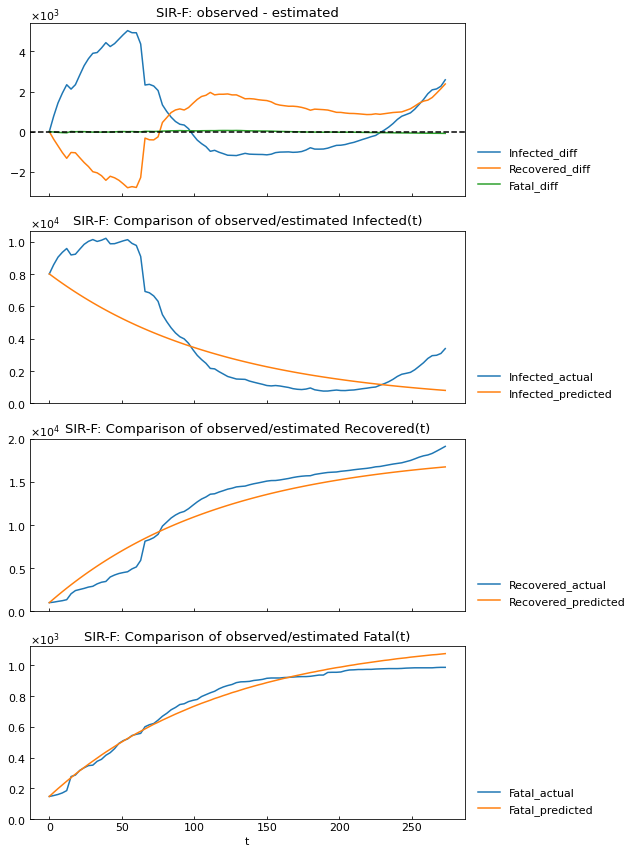

In [11]:
snl.estimate_accuracy(phase="1st")

### Get parameter value
We can get the parameter values of a phase using `Scenario.get()` method.

In [12]:
snl.get("Rt", phase="4th")

0.8

### Show parameter history
`Scenario.history()` method shows the trajectories of parameters (and the number of cases).

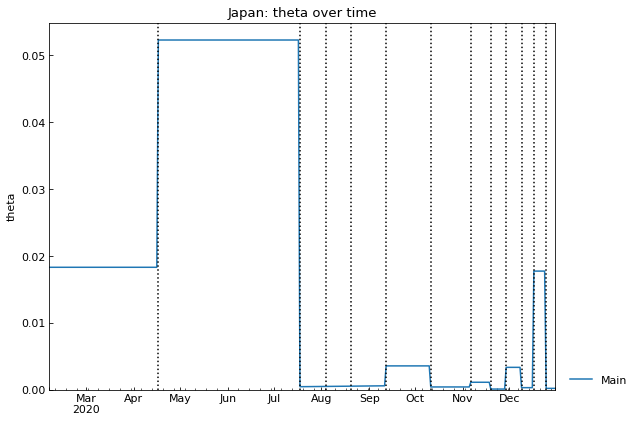

In [13]:
_ = snl.history(target="theta")

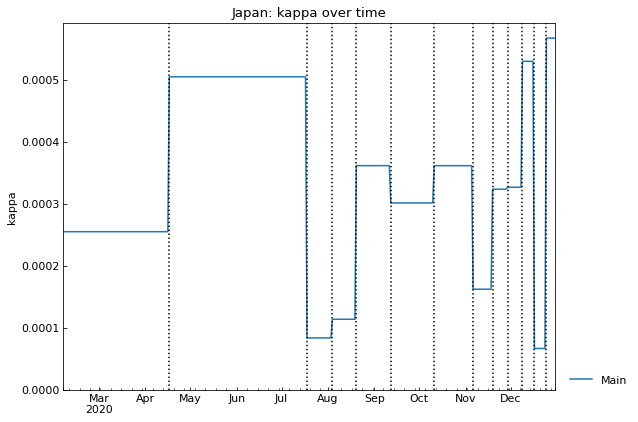

In [14]:
_ = snl.history(target="kappa")

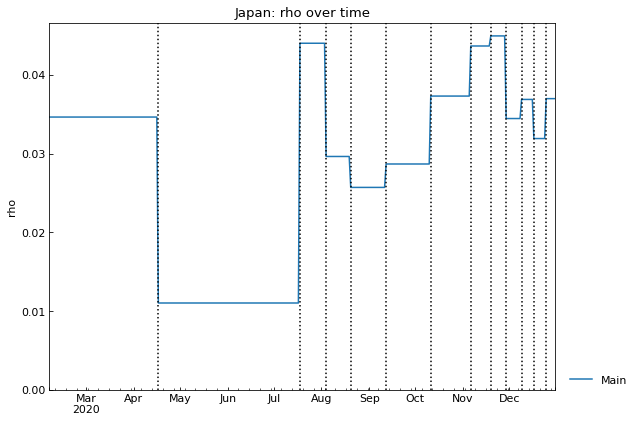

In [15]:
_ = snl.history(target="rho")

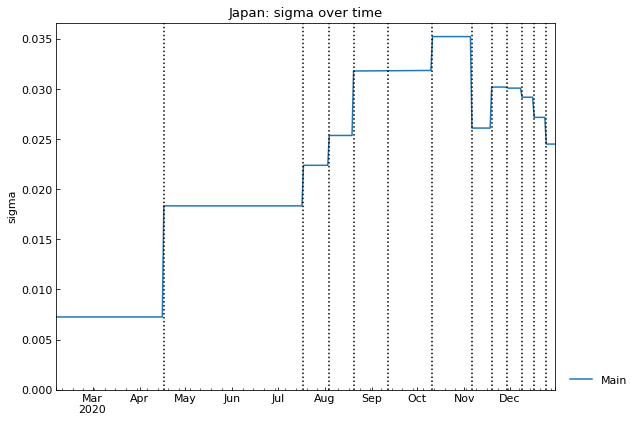

In [16]:
_ = snl.history(target="sigma")

Notes on the history of $\sigma$ value in japan (last updated: 28Dec2020):  
In Japan, we experienced two waves and we are in third wave. In the first wave (Apr - May), recovery period was too long because collapse of the medical care system occurred and no medicines were found.

Sigma values: the first wave < the second wave > the third wave

However, in the second wave (Jul - Oct), recovery period appears short because we have some effective medicines (not approved, in clinical study), yonger people (people un-associated to sever diseases) were infected.

In the third wave (Nov - ), older people tend to be infected and we are facing with medical collapse at this time...

### Show the history of reproduction number
$R_0$ ("R naught") means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)). When this value is larger than 1, the infection disease is outbreaking.

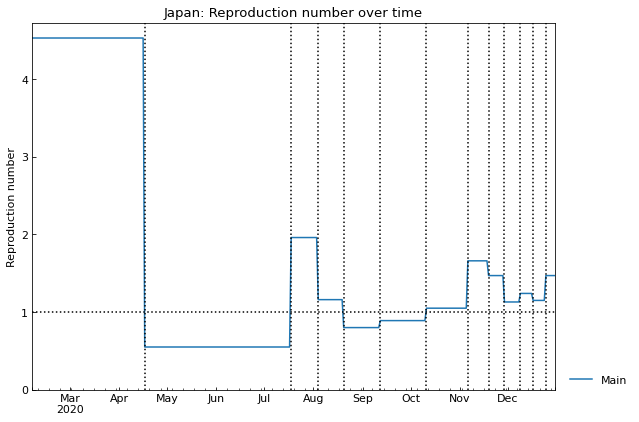

In [17]:
_ = snl.history(target="Rt")

### Simulate the number of cases
We can compare the actual and simulated (with estimated parameter values) number of confirmed/infected/recovered/fatal cases using `Scenario.history()` method.

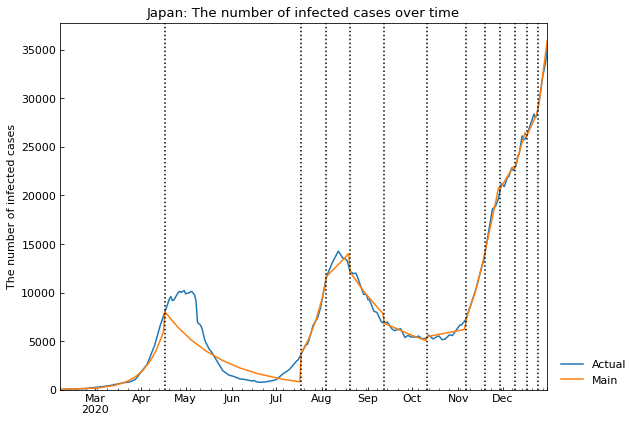

In [18]:
_ = snl.history("Infected")

### Main scenario
If the parameter velues will not be changed until 01Apr2021, how many cases will be? We call this scenario as "Main" scenario.

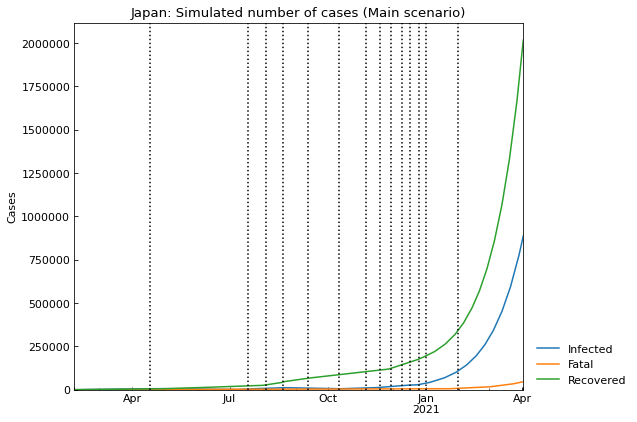

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,2591260,40532,777334,1773394
418,2021-03-30,2677112,41894,803726,1831492
419,2021-03-31,2765814,43303,830951,1891560
420,2021-04-01,2857448,44759,859029,1953660
421,2021-04-02,2952103,46265,887983,2017855


In [19]:
# Clear future phases in Main scenario
snl.clear(name="Main")
# Add one future phase 30 days with the parameter set of the last past phase
snl.add(days=30)
# Add one future phase until 01Apr2021 with the same parameter set
snl.add(end_date="01Apr2021", name="Main")
# Simulate the number of cases
snl.simulate(name="Main").tail()

### Medicine scenario
If $\sigma$ will be double in 30 days, how many cases will be? We will call this scenario as "Medicine" scenario.

In [20]:
# Calcuate the current sigma value of the last phase
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.024498894881875236

In [21]:
# Sigma value will be double
sigma_new = sigma_current * 2
sigma_new

0.04899778976375047

In [22]:
# Initialize "Medicine" scenario (with the same past phases as that of Main scenario)
snl.clear(name="Medicine")
# Add 30 days as a new future phases with the same parameter set
snl.add(name="Medicine", days=30, sigma=sigma_current)
# Add a phase until 01Apr2021 with doubled sigma value
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary(name="Medicine")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/beta [day],1/gamma [day],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,4.53,0.018303,0.000255,0.034633,0.007257,480,0.018,9,45,1307,0.258399,2007,3 min 1 sec
1st,Past,17Apr2020,17Jul2020,126529100,SIR-F,0.55,0.052285,0.000505,0.011014,0.018334,480,0.052,30,18,660,0.370748,2407,3 min 0 sec
2nd,Past,18Jul2020,03Aug2020,126529100,SIR-F,1.96,0.000447,0.000084,0.044007,0.022380,480,0.000,7,14,3988,0.0188002,2012,3 min 1 sec
3rd,Past,04Aug2020,19Aug2020,126529100,SIR-F,1.16,0.000594,0.000114,0.029625,0.025357,480,0.001,11,13,2932,0.0397522,2018,3 min 1 sec
4th,Past,20Aug2020,11Sep2020,126529100,SIR-F,0.80,0.000583,0.000362,0.025696,0.031786,480,0.001,12,10,922,0.0390381,475,0 min 30 sec
5th,Past,12Sep2020,10Oct2020,126529100,SIR-F,0.89,0.003560,0.000301,0.028670,0.031841,480,0.004,11,10,1106,0.0214895,292,0 min 20 sec
6th,Past,11Oct2020,05Nov2020,126529100,SIR-F,1.05,0.000410,0.000361,0.037298,0.035219,480,0.000,8,9,922,0.0391606,1999,3 min 1 sec
7th,Past,06Nov2020,18Nov2020,126529100,SIR-F,1.66,0.001112,0.000162,0.043659,0.026093,480,0.001,7,12,2056,0.0118625,295,0 min 20 sec
8th,Past,19Nov2020,28Nov2020,126529100,SIR-F,1.47,0.000095,0.000324,0.044939,0.030184,480,0.000,7,11,1030,0.0257511,2076,3 min 1 sec
9th,Past,29Nov2020,08Dec2020,126529100,SIR-F,1.13,0.003342,0.000327,0.034445,0.030079,480,0.003,9,11,1020,0.00753352,338,0 min 20 sec


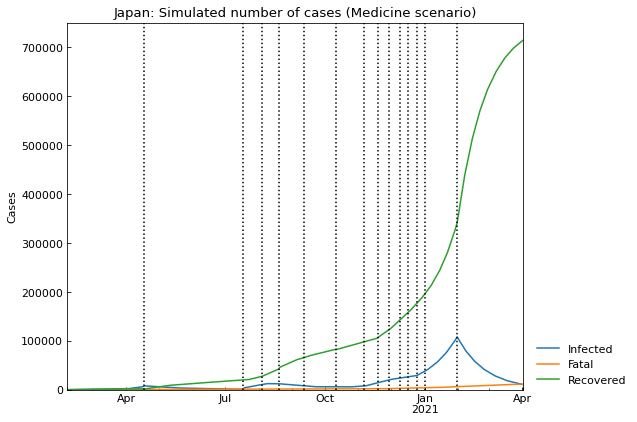

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,731944,11248,12132,708564
418,2021-03-30,733250,11269,11677,710304
419,2021-03-31,734507,11288,11238,711981
420,2021-04-01,735720,11307,10815,713598
421,2021-04-02,736889,11325,10407,715157


In [23]:
# Simulate the number of cases
snl.simulate(name="Medicine").tail()

### Short-term prediction of parameter values
With OxCGRT data, we can predict the parameter values of the future phases because [OxCGRT indicators](https://github.com/OxCGRT/covid-policy-tracker) (policy measures) impact on parameter values with delay (=recovery period).  

OxCGRT indicators are

- school_closing,
- workplace_closing,
- cancel_events, 
- gatherings_restrictions,
- transport_closing,
- stay_home_restrictions,
- internal_movement_restrictions,
- international_movement_restrictions,
- information_campaigns,
- testing_policy, and
- contact_tracing.

In [24]:
# Fitting with linear regression model (Elastic Net regression)
fit_dict = snl.fit(oxcgrt_data=oxcgrt_data, name="Forecast")
print(f"Determination coefficient: {fit_dict['score_train']} (train)")
print(f"Determination coefficient: {fit_dict['score_test']} (test)")
print("Intercept:")
fit_dict["intercept"].style.background_gradient(axis=None)

Determination coefficient: 0.6679213069183253 (train)
Determination coefficient: 0.737601071608816 (test)
Intercept:


,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing
theta,0.009439,0.015631,-0.016651,0.000000,0.005445,0.020568,0.015631,0.007325,-0.004894,-0.054341,0.046709
kappa,0.000021,0.000072,-0.000088,0.000000,0.000036,0.000213,0.000072,-0.000034,0.000031,-0.000283,0.000375
rho,-0.003107,-0.010618,0.011362,0.000000,-0.002787,-0.015211,-0.010618,-0.004673,0.003081,0.024964,-0.018414
sigma,-0.005972,0.001717,-0.002706,0.000000,-0.005622,0.012481,0.001717,-0.004299,0.003559,0.011799,-0.007903


In [25]:
# Short-term prediction
snl.predict(name="Forecast").summary(name="Forecast")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/beta [day],1/gamma [day],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,4.53,0.018303,0.000255,0.034633,0.007257,480,0.018,9,45,1307,0.258399,2007,3 min 1 sec
1st,Past,17Apr2020,17Jul2020,126529100,SIR-F,0.55,0.052285,0.000505,0.011014,0.018334,480,0.052,30,18,660,0.370748,2407,3 min 0 sec
2nd,Past,18Jul2020,03Aug2020,126529100,SIR-F,1.96,0.000447,0.000084,0.044007,0.022380,480,0.000,7,14,3988,0.0188002,2012,3 min 1 sec
3rd,Past,04Aug2020,19Aug2020,126529100,SIR-F,1.16,0.000594,0.000114,0.029625,0.025357,480,0.001,11,13,2932,0.0397522,2018,3 min 1 sec
4th,Past,20Aug2020,11Sep2020,126529100,SIR-F,0.80,0.000583,0.000362,0.025696,0.031786,480,0.001,12,10,922,0.0390381,475,0 min 30 sec
5th,Past,12Sep2020,10Oct2020,126529100,SIR-F,0.89,0.003560,0.000301,0.028670,0.031841,480,0.004,11,10,1106,0.0214895,292,0 min 20 sec
6th,Past,11Oct2020,05Nov2020,126529100,SIR-F,1.05,0.000410,0.000361,0.037298,0.035219,480,0.000,8,9,922,0.0391606,1999,3 min 1 sec
7th,Past,06Nov2020,18Nov2020,126529100,SIR-F,1.66,0.001112,0.000162,0.043659,0.026093,480,0.001,7,12,2056,0.0118625,295,0 min 20 sec
8th,Past,19Nov2020,28Nov2020,126529100,SIR-F,1.47,0.000095,0.000324,0.044939,0.030184,480,0.000,7,11,1030,0.0257511,2076,3 min 1 sec
9th,Past,29Nov2020,08Dec2020,126529100,SIR-F,1.13,0.003342,0.000327,0.034445,0.030079,480,0.003,9,11,1020,0.00753352,338,0 min 20 sec


In [26]:
# Or, when you do not need 'fit_dict'
# snl.fit_predict(oxcgrt_data=oxcgrt_data, name="Forecast").summary(name="Forecast")

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values.

In [27]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,Confirmed on 18Jan2021,Infected on 18Jan2021,Fatal on 18Jan2021,13th_Rt,14th_Rt
Main,887983,02Apr2021,2952103.0,887983.0,46265.0,NaN,NaN,NaN,1.47,1.47
Medicine,107869,31Jan2021,736889.0,10407.0,11325.0,NaN,NaN,NaN,1.47,0.75
Forecast,58787,18Jan2021,NaN,NaN,NaN,319275.0,58787.0,5037.0,1.35,-


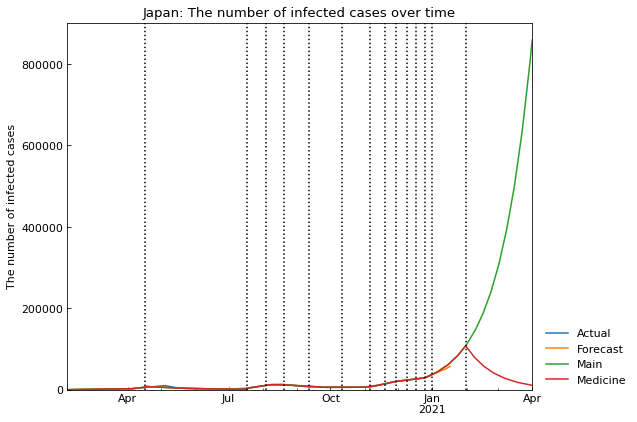

In [28]:
_ = snl.history(target="Infected")

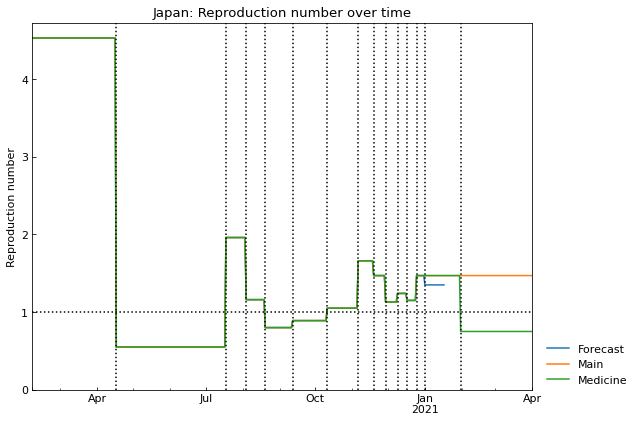

In [29]:
_ = snl.history(target="Rt")

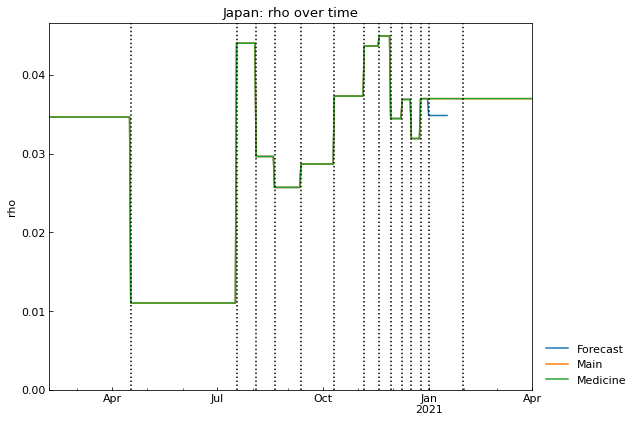

In [30]:
_ = snl.history(target="rho")

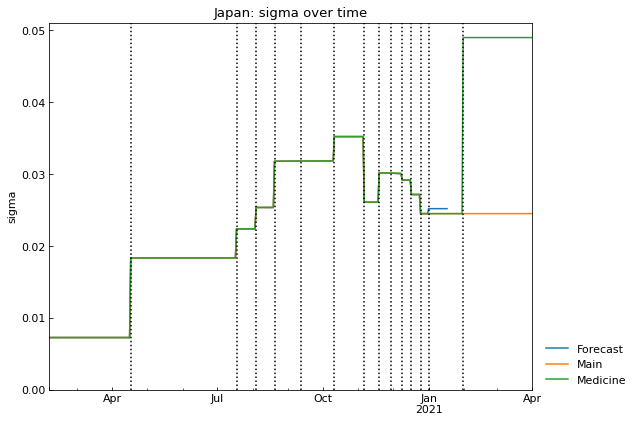

In [31]:
_ = snl.history(target="sigma")

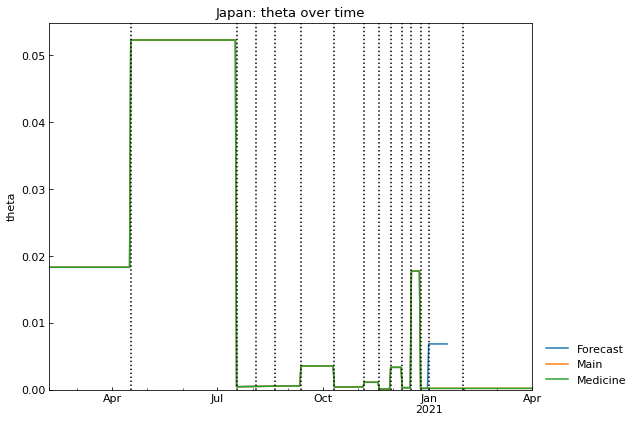

In [32]:
_ = snl.history(target="theta")

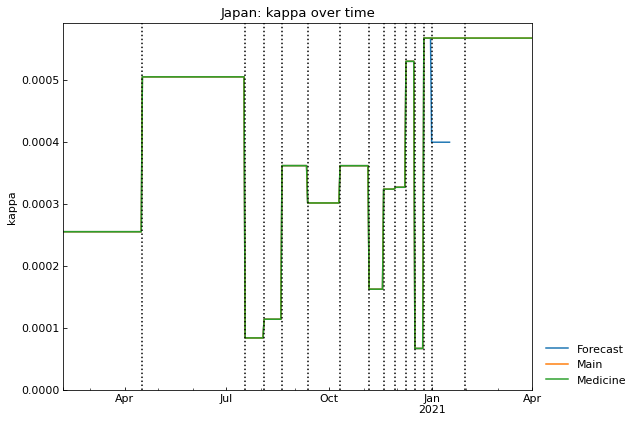

In [33]:
_ = snl.history(target="kappa")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

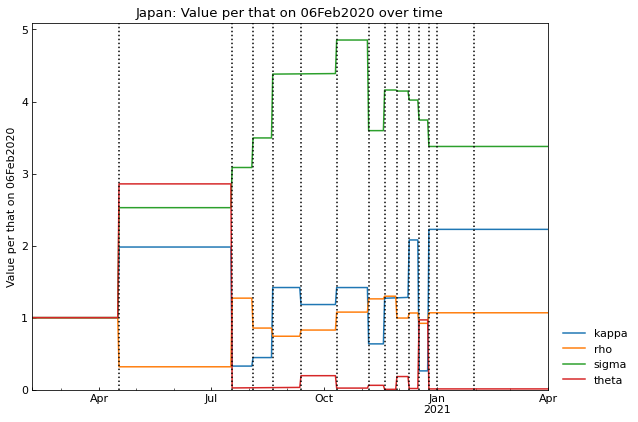

In [34]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [35]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 9th phase (19Nov2020 - 28Nov2020): finished 2345 trials in 3 min  1 sec


	 3rd phase (06Nov2020 - 18Nov2020): finished  307 trials in 0 min 20 sec

	 5th phase (12Sep2020 - 10Oct2020): finished  299 trials in 0 min 20 sec

	 1st phase (01Sep2020 - 11Sep2020): finished  168 trials in 0 min 10 sec

	10th phase (18Jul2020 - 03Aug2020): finished 2061 trials in 3 min  1 sec

	 2nd phase (11Oct2020 - 05Nov2020): finished 2031 trials in 3 min  1 sec

	 7th phase (06Feb2020 - 16Apr2020): finished 2033 trials in 3 min  0 sec

	 0th phase (20Aug2020 - 31Aug2020): finished  484 trials in 0 min 30 sec

	 8th phase (04Aug2020 - 19Aug2020): finished 2073 trials in 3 min  1 sec

	 4th phase (17Dec2020 - 24Dec2020): finished  328 trials in 0 min 20 sec

	11th phase (25Dec2020 - 31Dec2020): finished  620 trials in 0 min 40 sec

	12th phase (29Nov2020 - 08Dec2020): finished  361 trials in 0 min 20 sec

	13th phase (09Dec2020 - 16Dec2020): finished 1728 trials in 2 min  0 sec

	 6th phase (17Apr2020 - 17Jul2020): finished 2262 trials in 3 min  1 sec

Completed optimization. Total: 9 min  5 sec



<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 4th phase (01Sep2020 - 31Dec2020): finished 6362 trials in 3 min  0 sec

Completed optimization. Total: 3 min  1 sec


In [36]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  16Apr2020  SIR-F  4.53  0.018303  0.000255   
              1st    17Apr2020  17Jul2020  SIR-F  0.55  0.052285  0.000505   
              2nd    18Jul2020  03Aug2020  SIR-F  1.96  0.000447  0.000084   
              3rd    04Aug2020  19Aug2020  SIR-F  1.16  0.000594  0.000114   
              4th    20Aug2020  31Aug2020  SIR-F  0.82  0.000413  0.000361   
              5th    01Sep2020  11Sep2020  SIR-F  0.75  0.002565  0.000463   
              6th    12Sep2020  10Oct2020  SIR-F  0.89  0.003560  0.000301   
              7th    11Oct2020  05Nov2020  SIR-F  1.05  0.000410  0.000361   
              8th    06Nov2020  18Nov2020  SIR-F  1.66  0.001112  0.000162   
              9th    19Nov2020  28Nov2020  SIR-F  1.47  0.000095  0.000324   
              10th   29Nov2020  08Dec2020  SIR-F  1.13  0.003342  0.000327   
              11th   09Dec2020  16Dec2020  SIR-F  1.24  0.000305  0.000530   
              12th   17Dec2020  24Dec2020  SIR-F  1.14  0.000568  0.000427   
              13th   25Dec2020  31Dec2020  SIR-F  1.47  0.000201  0.000567   
Retrospective 0th    06Feb2020  16Apr2020  SIR-F  4.53  0.018303  0.000255   
              1st    17Apr2020  17Jul2020  SIR-F  0.55  0.052285  0.000505   
              2nd    18Jul2020  03Aug2020  SIR-F  1.96  0.000447  0.000084   
              3rd    04Aug2020  19Aug2020  SIR-F  1.16  0.000594  0.000114   
              4th    20Aug2020  31Aug2020  SIR-F  0.82  0.000413  0.000361   
              5th    01Sep2020  31Dec2020  SIR-F  0.82  0.000413  0.000361   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.034633  0.007257  0.258399    2033  3 min  0 sec  
              1st    0.011014  0.018334  0.370748    2262  3 min  1 sec  
              2nd    0.044007  0.022380  0.018800    2061  3 min  1 sec  
              3rd    0.029625  0.025357  0.039752    2073  3 min  1 sec  
              4th    0.028308  0.034166  0.019268     484  0 min 30 sec  
              5th    0.023867  0.031294  0.022408     168  0 min 10 sec  
              6th    0.028670  0.031841  0.021489     299  0 min 20 sec  
              7th    0.037298  0.035219  0.039161    2031  3 min  1 sec  
              8th    0.043659  0.026093  0.011863     307  0 min 20 sec  
              9th    0.044939  0.030184  0.025751    2345  3 min  1 sec  
              10th   0.034445  0.030079  0.007534     361  0 min 20 sec  
              11th   0.036871  0.029172  0.010384    1728  2 min  0 sec  
              12th   0.031708  0.027453  0.011802     328  0 min 20 sec  
              13th   0.036972  0.024499  0.008907     620  0 min 40 sec  
Retrospective 0th    0.034633  0.007257  0.258399    2033  3 min  0 sec  
              1st    0.011014  0.018334  0.370748    2262  3 min  1 sec  
              2nd    0.044007  0.022380  0.018800    2061  3 min  1 sec  
              3rd    0.029625  0.025357  0.039752    2073  3 min  1 sec  
              4th    0.028308  0.034166  0.019268     484  0 min 30 sec  
              5th    0.028308  0.034166  1.038163    6362  3 min  0 sec

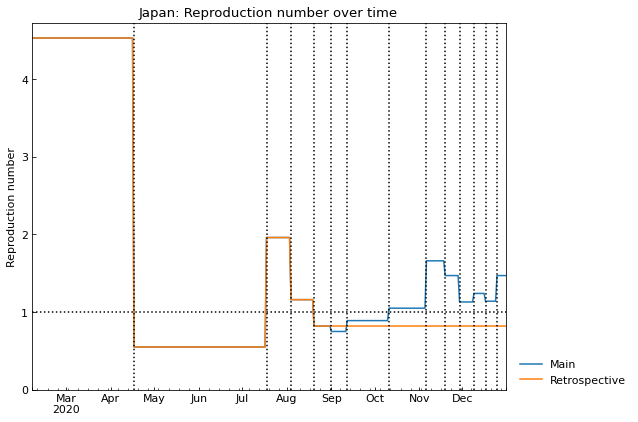

In [37]:
# History of reproduction number
_ = snl_retro.history("Rt")

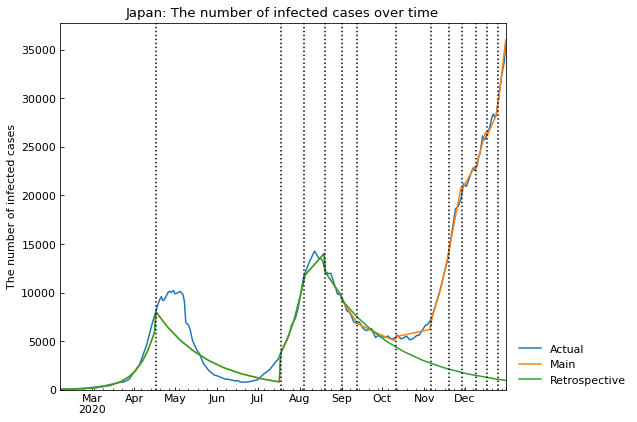

In [38]:
# History of Infected
_ = snl_retro.history("Infected")

In [39]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 01Jan2021,Infected on 01Jan2021,Fatal on 01Jan2021,5th_Rt,6th_Rt,7th_Rt,8th_Rt,9th_Rt,10th_Rt,11th_Rt,12th_Rt,13th_Rt
Main,37286,01Jan2021,235567,37286,3503,0.75,0.89,1.05,1.66,1.47,1.13,1.24,1.14,1.47
Retrospective,14020,19Aug2020,106090,943,1793,0.82,-,-,-,-,-,-,-,-
